## Prepare dataset

In [1]:
DATASET_NAME = "IXI"
DATA_PATH = "/data/galati/brain_data/IXI/selected"

#these functions are to define for each new dataset, unless fixing a rule
#they allow to define a clear association between the data path of a brain image and the corresponding brain/vessel mask
#the brain mask is not mandatory, if not present just return None
import utils
def img_path_to_brain_path(img_path):
    out_path = img_path.replace(".nii.gz", "_mask.nii.gz")
    if not os.path.isfile(out_path):
        return None
    return out_path
def img_path_to_vessel_path(img_path):
    out_path = img_path.replace(".nii.gz", "_vessel_mask2.nii.gz")
    if not os.path.isfile(out_path):
        return None
    return out_path
def img_path_to_weight_path(img_path):
    return None

utils.img_path_to_brain_path = img_path_to_brain_path
utils.img_path_to_vessel_path = img_path_to_vessel_path
utils.img_path_to_weight_path = img_path_to_weight_path

#this regex works as a filter in case you have unnecessary .nii files in your dataset folder
PATH_RULE = "^.*MRA.nii.gz$"

#if you have some outliers you want to discard, you can specify it in the list below
OUTLIERs = []

#if you need to preprocess also images with no vessel masks set the following flag to False
VESSELs_REQUIRED = False

#this parameter is to unify the orientation of our images
#set it True if you notice in the examples shown below that the nose is oriented downward and not upward
utils.do_flip = False

### Extract paths

In [2]:
import os

from utils import search_nii, extract_paths, load_info_from_checkpoint

In [3]:
if not os.path.isfile(f"info_{DATASET_NAME}.pkl"):
    info = {
        "train": extract_paths(path_rule=PATH_RULE),
        "val": None,
        "test": None,
    }
    search_nii(DATA_PATH, info["train"])
else:
    info = load_info_from_checkpoint(f"info_{DATASET_NAME}.pkl")

### Display examples

In [4]:
import random

from utils import print_bold, load_and_display_middle_slice

[Example 01]
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 512 512 100   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.          0.46875     0.46875     0.79999983  0.          0.
  0.          0.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'MR'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.028626269
quatern_c       : 0.9991467
quatern_d       : 0.014098608
qoffset_x       : 1

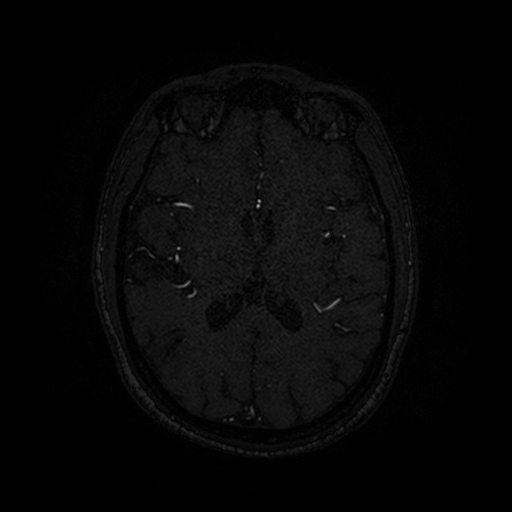

[Example 02]
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 512 512 100   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.          0.46875024  0.46875003  0.80000025  0.          0.
  0.          0.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'MR'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.005055392
quatern_c       : 0.99974513
quatern_d       : 0.011245856
qoffset_x       : 

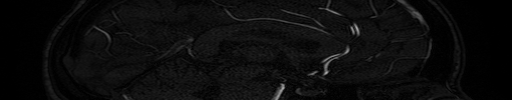

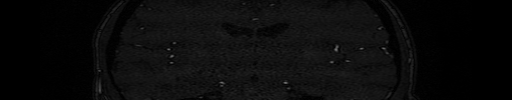

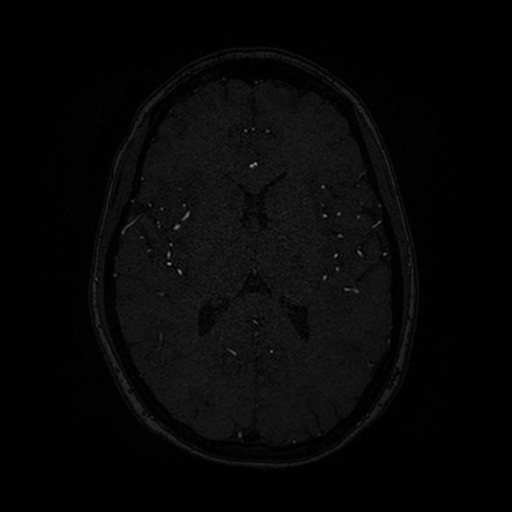

In [5]:
print_bold("[Example 01]")
random.seed(0)
load_and_display_middle_slice(random.choice(info["train"].paths), display_header=True)

print_bold("[Example 02]")
random.seed(1)
load_and_display_middle_slice(random.choice(info["train"].paths), axis=[0,1,2], display_header=True)

### Split train/val/test

In [5]:
from utils import is_medical_volume

In total, there are

In [6]:
IMGs = sum([
    info["train"].paths,
    info["val"].paths if info["val"] is not None else [],
    info["test"].paths if info["test"] is not None else []
], [])

len(IMGs)

50

volumes. First, we discard the outliers:

In [7]:
IMGs = [img_path for img_path in IMGs if os.path.basename(img_path) not in OUTLIERs]

len(IMGs)

50

We have vessel annotations for

In [8]:
HAVE_VESSELs = [
    img_path for img_path in IMGs if is_medical_volume(img_path_to_vessel_path(img_path))
]

len(HAVE_VESSELs)

22

of them. With a chosen ratio of 70-15-15, we select

In [9]:
COUNT_TEST = len(HAVE_VESSELs if VESSELs_REQUIRED else IMGs) * 15 // 100
COUNT_TEST

7

images to be part of the validation/testing set.

In case brain masks are available, we collect them too.

In [10]:
HAVE_BRAINs = [
    img_path for img_path in IMGs if is_medical_volume(img_path_to_brain_path(img_path))
]

len(HAVE_BRAINs)

50

Finally, we randomly split our dataset. 

In [11]:
random.seed(0)

VAL_IMGs = random.sample(sorted(HAVE_VESSELs), COUNT_TEST)

print("val: ", [os.path.basename(img) for img in VAL_IMGs])

random.seed(1)

TEST_IMGs = random.sample(sorted([img for img in HAVE_VESSELs if img not in VAL_IMGs]), COUNT_TEST)

print("test: ", [os.path.basename(img) for img in TEST_IMGs])

TRAIN_IMGs = [img for img in (HAVE_VESSELs if VESSELs_REQUIRED else IMGs) if img not in VAL_IMGs and img not in TEST_IMGs]

val:  ['IXI299-Guys-0893-MRA.nii.gz', 'IXI300-Guys-0880-MRA.nii.gz', 'IXI012-HH-1211-MRA.nii.gz', 'IXI021-Guys-0703-MRA.nii.gz', 'IXI308-Guys-0884-MRA.nii.gz', 'IXI307-IOP-0872-MRA.nii.gz', 'IXI315-IOP-0888-MRA.nii.gz']
test:  ['IXI015-HH-1258-MRA.nii.gz', 'IXI298-Guys-0861-MRA.nii.gz', 'IXI312-Guys-0887-MRA.nii.gz', 'IXI013-HH-1212-MRA.nii.gz', 'IXI017-Guys-0698-MRA.nii.gz', 'IXI311-Guys-0885-MRA.nii.gz', 'IXI023-Guys-0699-MRA.nii.gz']


In [13]:
random.seed(0); random.sample(sorted([img for img in TRAIN_IMGs if img in HAVE_VESSELs]), 3)

['/data/galati/brain_data/IXI/selected/IXI313-HH-2241-MRA.nii.gz',
 '/data/galati/brain_data/IXI/selected/IXI314-IOP-0889-MRA.nii.gz',
 '/data/galati/brain_data/IXI/selected/IXI020-Guys-0700-MRA.nii.gz']

In [13]:
import pickle

with open(f"info_{DATASET_NAME}.pkl", "wb") as file:
    pickle.dump({
        k: info[k].__dict__ if info[k] is not None else None for k in info
    }, file)

### Extract spacings and shapes

In [14]:
from utils import load_info_from_checkpoint

info = load_info_from_checkpoint(f"info_{DATASET_NAME}.pkl")

In [15]:
from utils import extract_info_and_masks, loop_nii, display_info, get_target_spacing

In [16]:
info = {
    "train": extract_info_and_masks(path_rule=PATH_RULE),
    "val": extract_info_and_masks(path_rule=PATH_RULE),
    "test": extract_info_and_masks(path_rule=PATH_RULE),
}

loop_nii(TRAIN_IMGs, info["train"])
loop_nii(VAL_IMGs, info["val"])
loop_nii(TEST_IMGs, info["test"])

In [17]:
display_info(info["train"], info["val"])

,#volumes,#slices,spacing median,spacing range,shape median,shape range
TRAIN,36,3592,[000.47 000.47 000.80],[000.26 000.26 000.80] - [000.47 000.47 000.80],[359.00 480.50 100.00],[318.00 411.00 092.00] - [619.00 870.00 100.00]
VAL,7,684,[000.47 000.47 000.80],[000.26 000.26 000.80] - [000.47 000.47 000.80],[380.00 488.00 100.00],[362.00 433.00 092.00] - [653.00 867.00 100.00]


In [18]:
SPACING = get_target_spacing(
    info["train"].spacings + info["val"].spacings,
    info["train"].shapesAfterCropping() + info["val"].shapesAfterCropping()
)

SPACING

array([0.46875   , 0.46875   , 0.79999995])

In [19]:
import pickle

with open(f"info_{DATASET_NAME}.pkl", "wb") as file:
    pickle.dump({
        k: info[k].__dict__ if info[k] is not None else None for k in info
    }, file)

### Crop, Metadata, Resize, Empty Slices Removal, Standardization

In [20]:
from utils import load_info_from_checkpoint

info = load_info_from_checkpoint(f"info_{DATASET_NAME}.pkl")

In [21]:
import os

from utils import print_bold, preprocessing_loop

In [22]:
print_bold("Training")
preprocessing_loop(
    info["train"],
    os.path.join("numpy", "train"),
    target_spacing=SPACING
)

print_bold("Validation")
preprocessing_loop(
    info["val"],
    os.path.join("numpy", "val"),
    target_spacing=SPACING
)

print_bold("Testing")
preprocessing_loop(
    info["test"],
    os.path.join("numpy", "test"),
    target_spacing=SPACING
)

Training
Slices processed: 99
Slices processed: 198
Slices processed: 297
Slices processed: 396
Slices processed: 495
Slices processed: 594
Slices processed: 693
Slices processed: 792
Slices processed: 891
Slices processed: 990
Slices processed: 1089
Slices processed: 1188
Slices processed: 1287
Slices processed: 1386
Slices processed: 1485
Slices processed: 1584
Slices processed: 1683
Slices processed: 1782
Slices processed: 1881
Slices processed: 1980
Slices processed: 2079
Slices processed: 2178
Slices processed: 2269
Slices processed: 2368
Slices processed: 2467
Slices processed: 2566
Slices processed: 2665
Slices processed: 2764
Slices processed: 2863
Slices processed: 2962
Slices processed: 3061
Slices processed: 3160
Slices processed: 3259
Slices processed: 3358
Slices processed: 3457
Slices processed: 3556
Validation
Slices processed: 99
Slices processed: 198
Slices processed: 297
Slices processed: 396
Slices processed: 495
Slices processed: 586
Slices processed: 677
Testing
Sl

In [23]:
import pickle

with open(f"info_{DATASET_NAME}.pkl", "wb") as file:
    pickle.dump({
        k: info[k].__dict__ if info[k] is not None else None for k in info
    }, file)

### Outliers removal and slices extraction

In [24]:
from utils import load_info_from_checkpoint

info = load_info_from_checkpoint(f"info_{DATASET_NAME}.pkl")

In [25]:
import os

from utils import print_bold, extraction_loop, display_slice

In [26]:
print_bold("Training")
extraction_loop(
    info["train"],
    os.path.join("slices", "train")
)

print_bold("Validation")
extraction_loop(
    info["val"],
    os.path.join("slices", "val")
)

print_bold("Testing")
extraction_loop(
    info["test"],
    os.path.join("slices", "test")
)

Training


100%|████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:02<00:00, 12.28it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 12.24it/s]


Testing


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 12.42it/s]


In [27]:
import pickle

with open(f"info_{DATASET_NAME}.pkl", "wb") as file:
    pickle.dump({
        k: info[k].__dict__ if info[k] is not None else None for k in info
    }, file)

### Intensity values analysis

In [28]:
from utils import load_info_from_checkpoint

info = load_info_from_checkpoint(f"info_{DATASET_NAME}.pkl")

In [29]:
import numpy as np

from utils import intensity_loop, display_intensity
from utils import get_percentile, display_clipped_slice

Training


100%|████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:16<00:00,  2.17it/s]


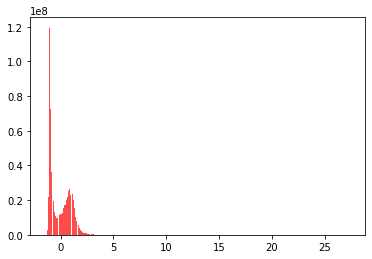

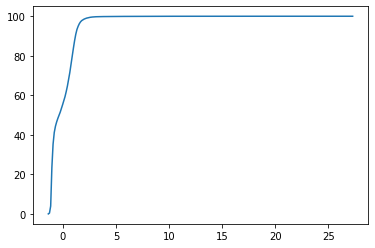

Validation


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.81it/s]


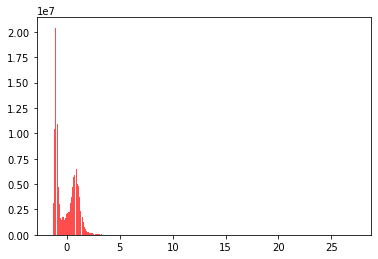

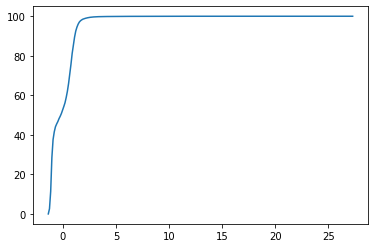

In [30]:
print_bold("Training")
intensity_loop(
    info["train"],
    min_value=min(info["train"].min_values + info["val"].min_values),
    max_value=max(info["train"].max_values + info["val"].max_values)
)
display_intensity(info["train"])

print_bold("Validation")
intensity_loop(
    info["val"],
    min_value=min(info["train"].min_values + info["val"].min_values),
    max_value=max(info["train"].max_values + info["val"].max_values)
)
display_intensity(info["val"])

In [31]:
MIN_VALUE = get_percentile(
    info["train"].bins,
    info["train"].intensity_count + info["val"].intensity_count,
    0.1
)
MAX_VALUE = get_percentile(
    info["train"].bins,
    info["train"].intensity_count + info["val"].intensity_count,
    99.9
)

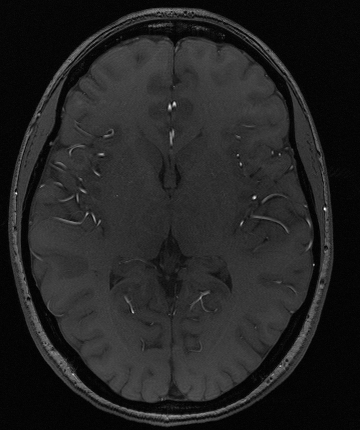

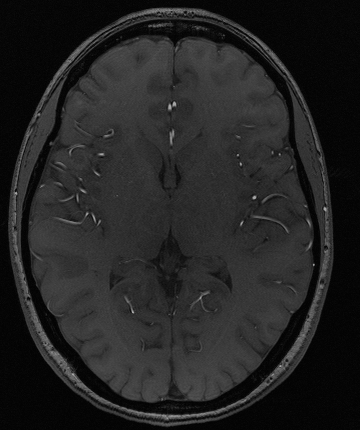

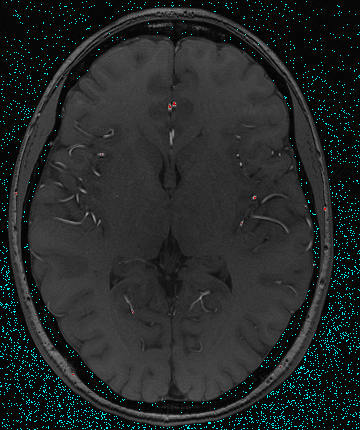

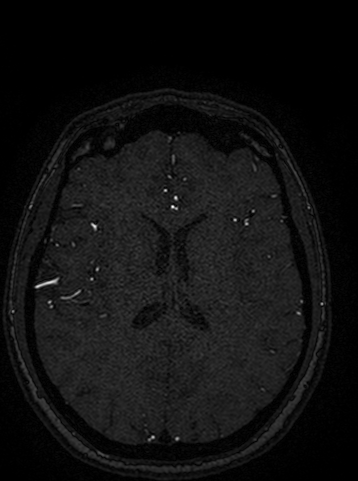

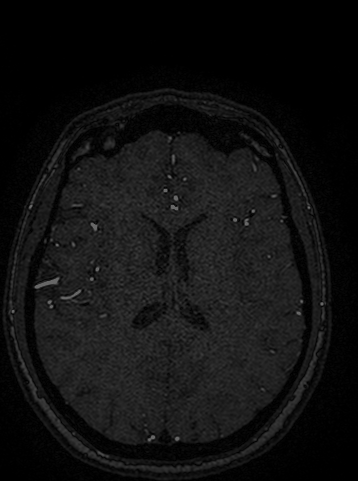

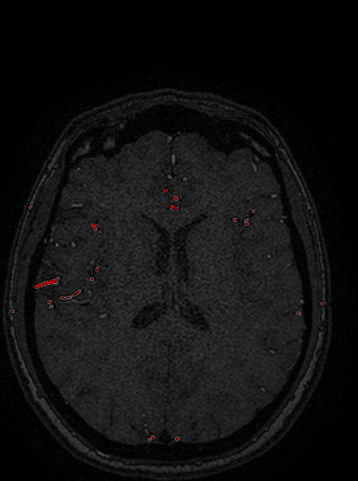

In [34]:
min_values_idx = np.argmin(
    info["train"].min_values + info["val"].min_values
)
DARK = (info["train"].preprocessed_paths + info["val"].preprocessed_paths)[min_values_idx]
DARK = DARK.replace("numpy/", "slices/").replace(".npy", "_slice{:03d}.npy").format(50)
display_clipped_slice(DARK, MIN_VALUE, MAX_VALUE)

max_values_idx = np.argmax(
    info["train"].max_values + info["val"].max_values
)
BRIGHT = (info["train"].preprocessed_paths + info["val"].preprocessed_paths)[max_values_idx]
BRIGHT = BRIGHT.replace("numpy/", "slices/").replace(".npy", "_slice{:03d}.npy").format(50)
display_clipped_slice(BRIGHT, MIN_VALUE, MAX_VALUE)

In [35]:
import pickle

with open(f"info_{DATASET_NAME}.pkl", "wb") as file:
    pickle.dump({
        k: info[k].__dict__ if info[k] is not None else None for k in info
    }, file)

### Normalization, Padding & Cropping, One-Hot Encoding

In [36]:
from utils import load_info_from_checkpoint

info = load_info_from_checkpoint(f"info_{DATASET_NAME}.pkl")

In [37]:
import numpy as np

from utils import display_slice, normalization_loop

In [38]:
print_bold("Training")
normalization_loop(info["train"], f"preprocess_{DATASET_NAME}/train", MIN_VALUE, MAX_VALUE)#, delete_old=False)#TO DELETE

print_bold("Validation")
normalization_loop(info["val"], f"preprocess_{DATASET_NAME}/val", MIN_VALUE, MAX_VALUE)#, delete_old=False)#TO DELETE

print_bold("Testing")
normalization_loop(info["test"], f"preprocess_{DATASET_NAME}/test", MIN_VALUE, MAX_VALUE)#, delete_old=False)#TO DELETE

Training


100%|████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:41<00:00,  1.17s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.15s/it]


Testing


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.18s/it]


In [39]:
np.save(f"preprocess_map_{DATASET_NAME}.npy", {
    "train": sorted(os.listdir(f"preprocess_{DATASET_NAME}/train")),
    "val": sorted(os.listdir(f"preprocess_{DATASET_NAME}/val")),
    "test": sorted(os.listdir(f"preprocess_{DATASET_NAME}/test")),
})

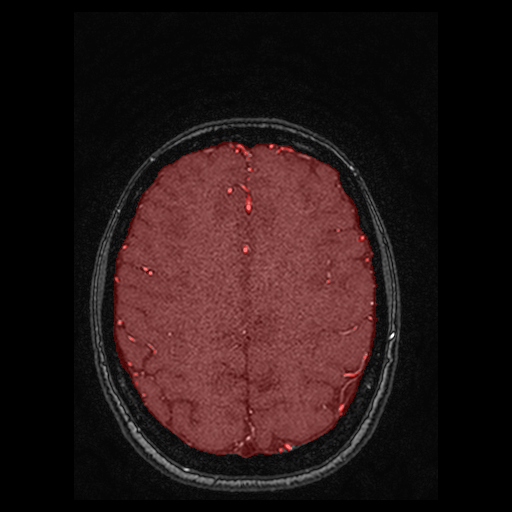

In [50]:
img_example = np.load(
    f"preprocess_{DATASET_NAME}/train/IXI002-Guys-0828-MRA_slice090.npy", allow_pickle=True
).item()

img_example, msk_example = img_example["data"][:,:,0], img_example["mask"]

msk_example = np.argmax(msk_example, axis=-1)

display_slice(img_example, min_val=-1, max_val=1, mask=msk_example/2)